## Setup

### Installs, Packages, Seeds

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mp_image
from IPython import display    # Easily show images in notebook
import os
# import cv2
# import numpy as np
# from skimage import io
from PIL import Image
from google.colab import drive # Connect colab to google drive
# from glob import glob
# from pathlib import PurePath

### Mount Google Drive

In [ ]:
drive.mount('/drive') 
%cd /drive/MyDrive/W210 - Capstone/

Mounted at /drive
/drive/MyDrive/W210 - Capstone


In [ ]:
%ls ./Data/

 archive/                      dermnet/                    ISIC_2018/
'Data Classification.gsheet'   diverse_stanford/           ISIC_2020/
 data_dictionary.csv           diverse_stanford_resized/   kaggle/
 data_dictionary.gsheet        full_data.csv               UCI/


In [ ]:
full_data_dict = pd.read_csv('./Data/data_dictionary.csv', index_col = 0)
# data_dict = full_data_dict[['diagnosis', 'grouping_1']]

# Some cleanup
full_data_dict['diagnosis'] = full_data_dict['diagnosis'].str.lower()
full_data_dict['diagnosis'] = full_data_dict['diagnosis'].str.strip()
full_data_dict['grouping_1'] = full_data_dict['grouping_1'].fillna('Unclassified - See Doctor')

# convert to dictionary
data_dict = dict(zip(full_data_dict['diagnosis'], 
                     full_data_dict['grouping_1']))

In [ ]:
pd.Series(data_dict.values()).unique()

array(['Autoimmue Disorder', 'Benign Marking or Mole',
       'Non-Cancerous Skin Condition',
       'Potentially Malignant Skin Tumors',
       'Toxin, Fungal, Bug, Viral, or Bacterial Infections',
       'Unclassified'], dtype=object)

In [36]:
data = pd.read_csv('./Data/full_data.csv', index_col = 0)

# Joining on diagnosis, so want to make sure we're not missing anything due to case
# data['diagnosis'] = data['diagnosis'].str.lower()
# data['diagnosis'] = data['diagnosis'].str.strip()
# data['age'] = data['age'].fillna(0)
# data['sex'] = data['sex'].fillna('unknown')
# data['localization'] = data['localization'].fillna('unknown')
# data['severity'] = data['severity'].fillna('unknown')

### join in one of the groupings for EDA

In [ ]:
# # First, count rows to make sure we're not creating data
# print(len(data['diagnosis']))

# # Then join
# # merged = data.merge(data_dict, on = 'diagnosis', how = 'left').reset_index(drop = True)
# data['class'] = data['diagnosis'].map(data_dict)
# print(len(data))

63356
63356


In [ ]:
# data.to_csv('./Data/full_data.csv')

## EDA

In [ ]:
# merged[merged['image_id'] == '000112']
source = data#_dict
cols= source.columns 
for col in cols: 
    print(col, source[col].isna().sum())

image_id 0
diagnosis 0
age 0
sex 0
localization 0
source 0
severity 0
path 0
class 0


### Next, check for duplicates

We can see first that dermnet has duplicates. Let's explore this further

In [38]:
data[data.image_id.duplicated(keep = False) == True].sort_values('image_id').source.value_counts()

dermnet    1401
Name: source, dtype: int64

Looks like the duplicates happen when a single image is used in a few different diagnosis groups. Each of these groups has a separate folder. 

In [39]:
data[(data.image_id.duplicated(keep = False) == True) & (data.source == 'dermnet')].sort_values('image_id').head()

,image_id,diagnosis,age,sex,localization,source,severity,path,class
7558,03DermatitisLids,eczema photos,0.0,unknown,unknown,dermnet,unknown,./Data/dermnet/train/Atopic Dermatitis Photos/...,Non-Cancerous Skin Condition
14517,03DermatitisLids,atopic dermatitis photos,0.0,unknown,unknown,dermnet,unknown,./Data/dermnet/train/Atopic Dermatitis Photos/...,Non-Cancerous Skin Condition
241,03DermatitisLids1,eczema photos,0.0,unknown,unknown,dermnet,unknown,./Data/dermnet/test/Atopic Dermatitis Photos/0...,Non-Cancerous Skin Condition
3314,03DermatitisLids1,atopic dermatitis photos,0.0,unknown,unknown,dermnet,unknown,./Data/dermnet/test/Atopic Dermatitis Photos/0...,Non-Cancerous Skin Condition
243,05hyperkeratosis01010,eczema photos,0.0,unknown,unknown,dermnet,unknown,./Data/dermnet/test/Atopic Dermatitis Photos/0...,Non-Cancerous Skin Condition


Let's see how often the 'class' we researched/assigned differs for the same image. In cases where class is the same, we can drop the duplicates without any issue. 

In [40]:
# Get the list of duplicates
duplicates = data[data.image_id.duplicated(keep = False) == True].sort_values('image_id')

# Group by image_id, counting unique classes
dup_group = duplicates.groupby('image_id')['class'].nunique()

# Where we see > 1, that means two calss values exist. This is a problem. 
# Let's isolate the image_ids with this issue
dup_ids = dup_group[dup_group > 1].index

Here we can isolate the image_ids with two or more diagnoses, and two or more classes. Let's export this to excel for further analysis

In [41]:
problems = data[data.image_id.isin(dup_ids)].sort_values('image_id')
# problems.to_csv('./Data/problems.csv')

This is a fairly complex set of duplicates, with no obvious way to choose which we should retain. For now, we will likely remove these duplicates altogether. 

Let's look at some of the "unknown" categorized data in ISIC_2020

In [ ]:
data[(data['sex'] == 'unknown') | 
     (data['localization'] == 'unknown') | 
     (data['severity'] == 'unknown') |
     (data['age'] == 0)
     ].groupby('source').count().rename(columns = {'image_id': 'count missing'}).reset_index()[['source', 'count missing']]

,source,count missing
0,ISIC_2018,10015
1,ISIC_2020,597
2,dermnet,19559
3,stanford_diverse,656


In [ ]:
pd.DataFrame(missing_df).reset_index().rename(columns = {'image_id': 'count'})

,source,count
0,ISIC_2018,10015
1,ISIC_2020,597
2,dermnet,19559
3,stanford_diverse,656


In [ ]:
# a = data.groupby(['source', 'sex', 'localization', 'age']).count().reset_index()
# a[(a['sex'] == 'unknown') | 
#      (a['localization'] == 'unknown') | 

#      (a['age'] == 0)
#      ]

In [ ]:
# # cols = ['age', 'sex', 'localization', 'source', 'severity', 'class']
# cols = ['sex', 'localization', 'source', 'severity', 'class', 'age']

# for col in cols: 
#     # print(col, '\n',data[col].value_counts(), '\n')
#     plt.hist(data[col], bins = len(data[col].unique()))
#     plt.xticks(rotation = 'vertical')
#     plt.title('Histogram: ' + col)
#     plt.show()
#     print(data[col].value_counts())

In [ ]:
s = data.path.sample(9)
s.iloc[0]


'./Data/ISIC_2020/Data/ISIC_5152619.jpg'

In [ ]:
# display.Image(paths.iloc[5])

In [ ]:
dx_type = pd.Series()
image_ids = pd.Series()
dataset = pd.Series()

for diagnosis in data['class'].unique():
    dx_type = dx_type.append(pd.Series(diagnosis).repeat(5))
    image_ids = image_ids.append(data[data['class'] == diagnosis]['path'].sample(5))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
image_ids.reset_index(inplace = True, drop = True)
dx_type.reset_index(inplace = True, drop = True)
samples = pd.concat([image_ids, dx_type], axis = 1)
samples = samples.rename(columns = {0: "image_id", 1: "diagnosis"})


In [ ]:
samples['image_id'].to_string()

'0     ./Data/ISIC_2018/Train/HAM10000_images_part_1_...\n1     ./Data/ISIC_2018/Train/HAM10000_images_part_1_...\n2                ./Data/ISIC_2020/Data/ISIC_0595080.jpg\n3     ./Data/ISIC_2018/Train/HAM10000_images_part_1_...\n4     ./Data/dermnet/train/Seborrheic Keratoses and ...\n5                ./Data/ISIC_2020/Data/ISIC_2732720.jpg\n6                ./Data/ISIC_2020/Data/ISIC_8754527.jpg\n7                ./Data/ISIC_2020/Data/ISIC_2874218.jpg\n8                ./Data/ISIC_2020/Data/ISIC_5113684.jpg\n9                ./Data/ISIC_2020/Data/ISIC_0533498.jpg\n10    ./Data/dermnet/test/Actinic Keratosis Basal Ce...\n11    ./Data/ISIC_2018/Train/HAM10000_images_part_1_...\n12    ./Data/dermnet/train/Actinic Keratosis Basal C...\n13    ./Data/ISIC_2018/Train/HAM10000_images_part_1_...\n14    ./Data/ISIC_2018/Train/HAM10000_images_part_1_...\n15    ./Data/dermnet/test/Warts Molluscum and other ...\n16    ./Data/dermnet/train/Tinea Ringworm Candidiasi...\n17    ./Data/dermnet/test/Wart

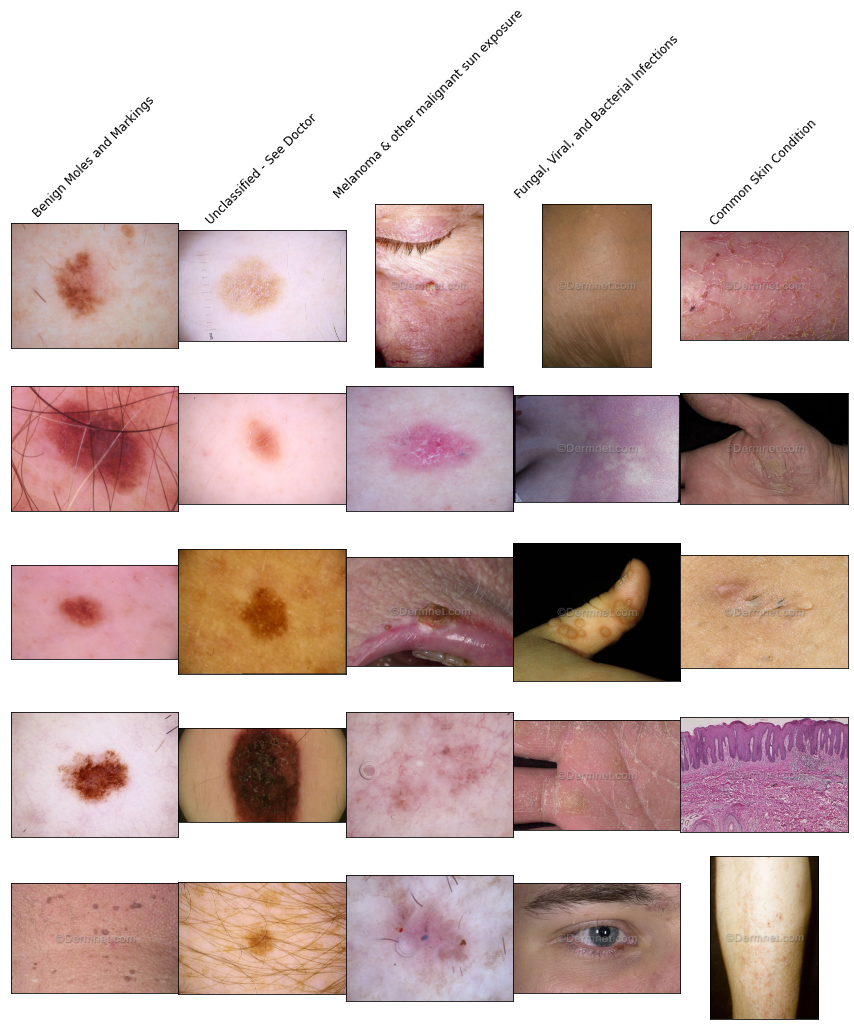

In [ ]:
n_samples = 5
diagnoses = 5
img_count = 0

fig, axes = plt.subplots(nrows = n_samples, ncols = diagnoses, figsize = (15, 15))

for j in range(diagnoses):
    for i in range(n_samples):
        if img_count < len(samples):
            path = samples['image_id'].iloc[img_count]
            # image = mp_image.imread(train_path + 'HAM10000_images_part_1_and_2/' + samples.image_id[img_count]+'.jpg')
            image = mp_image.imread(path)

            if i == 0:
                axes[i, j].set_title(samples.diagnosis[img_count], rotation = 45)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            axes[i, j].imshow(image)
            img_count += 1
plt.subplots_adjust(wspace = 0, hspace = 0)

In [ ]:
# word_list = full_data_csv.diagnosis.str\
#                                    .cat(sep = ' ')\
#                                    .replace('-', ' ')\
#                                    .split()


In [ ]:
# pd.set_option('display.max_rows', None)
# counts = pd.Series(word_list).value_counts()
# counts[counts.values >= 2]
# pd.Series(word_list).value_counts()[pd.Series(word_list).value_counts().values >= 2]

In [ ]:
# full_data[full_data['diagnosis'] == 'unknown']['path']